https://youtu.be/oBIkr7CAE6g

Binary semantic segmentation using U-Net
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

In [1]:
pip install keras-unet-collection

Note: you may need to restart the kernel to use updated packages.


In [1]:
from keras_unet_collection import losses

In [2]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob

In [3]:
image_directory = 'data/training/images'
gt_directory = 'data/training/groundtruth'
SIZE = 400
PATCH_SIZE = 16

In [4]:
# store train RGB images
image_names = glob.glob(image_directory + '/*.png')
#images = [cv2.imread(img) for img in image_names]
images = [cv2.resize(cv2.imread(img),(SIZE,SIZE)) for img in image_names]
image_dataset = np.array(images)


In [5]:
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
#gt = [cv2.imread(gt,0) for gt in gt_names]
gt = [cv2.resize(cv2.imread(gt,0),(SIZE,SIZE)) for gt in gt_names]
gt_dataset = np.array(gt)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [6]:
print("Image data shape is: ", image_dataset.shape)
print("gt data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 400, 400, 3)
gt data shape is:  (100, 400, 400, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 2

In [7]:
# binary labels
# store gt greyscale images
gt_names = glob.glob(gt_directory + '/*.png')
# resize and define binary threshold
gt_dataset = []
for gt in gt_names:
    gt_img = cv2.imread(gt,0)
    gt_img = cv2.resize(gt_img,(SIZE,SIZE))
    _,gt_img = cv2.threshold(gt_img, 120, 255, cv2.THRESH_BINARY)
    gt_dataset.append(gt_img)

gt_dataset = np.array(gt_dataset)
gt_dataset = np.expand_dims(gt_dataset, axis = 3)

In [8]:
print("Image data shape is: ", image_dataset.shape)
print("get data shape is: ", gt_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("unique pixel values in gt are  : ", np.unique(gt_dataset))

Image data shape is:  (100, 400, 400, 3)
get data shape is:  (100, 400, 400, 1)
Max pixel value in image is:  255
unique pixel values in gt are  :  [  0 255]


In [9]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [10]:
# Extract patches from input images

n = len(image_dataset)

img_patches = [img_crop(image_dataset[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]
gt_patches = [img_crop(gt_dataset[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [11]:
#Normalize images
img_patches = img_patches /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
gt_patches = gt_patches /255.  #PIxel values will be 0 or 1

In [12]:
back = np.sum(gt_patches == 1,axis=(0,1,2))
road = np.sum(gt_patches == 0,axis=(0,1,2))
road/(back+road)[0]

array([0.79910594])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_patches, gt_patches, test_size = 0.20,random_state=43)


In [14]:
X_test.shape

(12500, 16, 16, 3)

In [15]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
IMG_HEIGHT = img_patches.shape[1]
IMG_WIDTH  = img_patches.shape[2]
IMG_CHANNELS = img_patches.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
def loss_fn(y_true, y_pred):
    return losses.focal_tversky(y_true, y_pred, alpha=0.2)

In [28]:
import tensorflow.compat.v1.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
    


In [35]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## First model

In [38]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=dice_coef_loss, metrics=['accuracy',f1_m])


sigmoid


In [39]:
fit = model.fit(X_train, y_train, 
                    batch_size = 512, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/100


2021-12-14 12:28:35.462906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.7437 - f1_m: 0.2726

2021-12-14 12:29:56.860747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 86s 853ms/step - loss: 0.1159 - accuracy: 0.7437 - f1_m: 0.2726 - val_loss: 0.2167 - val_accuracy: 0.2612 - val_f1_m: 0.3361
Epoch 2/100
98/98 [==============================] - 80s 802ms/step - loss: 0.0697 - accuracy: 0.8376 - f1_m: 0.4580 - val_loss: 0.2914 - val_accuracy: 0.2218 - val_f1_m: 0.3372
Epoch 3/100
98/98 [==============================] - 117s 1s/step - loss: 0.0613 - accuracy: 0.8542 - f1_m: 0.5570 - val_loss: 0.2489 - val_accuracy: 0.3621 - val_f1_m: 0.3626
Epoch 4/100
98/98 [==============================] - 71s 708ms/step - loss: 0.0571 - accuracy: 0.8637 - f1_m: 0.5962 - val_loss: 0.1981 - val_accuracy: 0.5741 - val_f1_m: 0.4152
Epoch 5/100
98/98 [==============================] - 71s 714ms/step - loss: 0.0529 - accuracy: 0.8742 - f1_m: 0.6347 - val_loss: 0.1478 - val_accuracy: 0.6737 - val_f1_m: 0.4849
Epoch 6/100
98/98 [==============================] - 66s 659ms/step - loss: 0.0491 - accuracy: 0.8833 - f1_m: 0.6657 - val_l

In [40]:
#Save the model for future use
model.save('first_model_patched.h5')

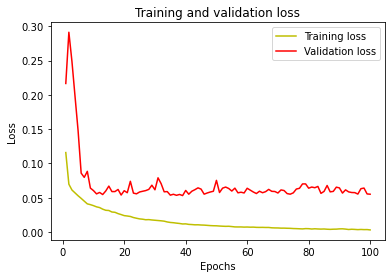

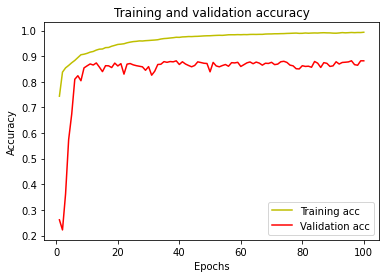

In [41]:
#plot the training and validation accuracy and loss at each epoch
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
#Load previously saved model
from keras.models import load_model
model = load_model('first_model_patched.h5', compile=False)


NameError: name 'y_pred' is not defined

In [31]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

2021-12-14 07:43:39.061714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [32]:
from tensorflow.keras.metrics import MeanIoU

In [33]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.67970055


In [111]:
test_img_names = glob.glob('data/test_set_images/*/*.png')
test_img_names.sort()
test_images = np.array([cv2.imread(img) for img in test_img_names])
test_images.shape

(50, 608, 608, 3)

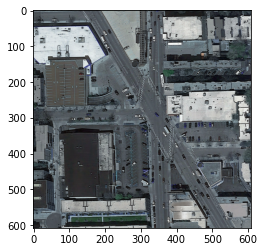

In [113]:
import random
X_test = random.randint(0, len(test_images)-1)
plt.imshow(test_images[image_number])

In [49]:
horizontal_slices = []
#for patch in X_test:
    #for i in range (1,37):
        #cv2.hconcat()
    
    
print(X_test.shape)
X_test_chunks = np.array(np.split(X_test,20))
print(X_test_chunks.shape)
for chunk in X_test_chunks:
    horizontal_slices = np.array(np.split(chunk,38)).shape
    horizontal_slices.reshape(608,608,3)

(28880, 16, 16, 3)
(20, 1444, 16, 16, 3)


AttributeError: 'tuple' object has no attribute 'reshape'

(1, 608, 608, 3)
(608, 608)


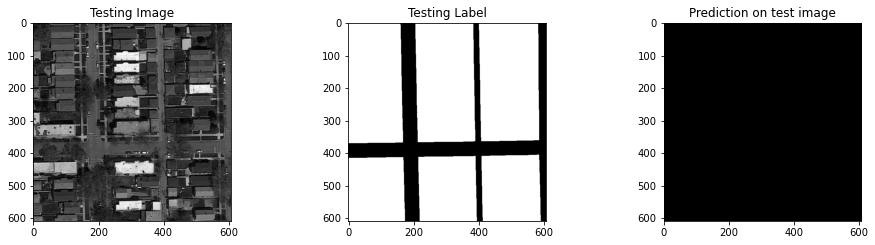

In [58]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()